# Brain Tumor Segmentation (BraTS) with OpenVINO™

In this code example, we apply the U-Net architecture to segment brain tumors from raw MRI scans. With relatively little data we are able to train a U-Net model to accurately predict where tumors exist. 

The Dice coefficient (the standard metric for the BraTS dataset used in the study) for our model is about 0.82-0.88.  Menze et al. [reported](http://ieeexplore.ieee.org/document/6975210/) that expert neuroradiologists manually segmented these tumors with a cross-rater Dice score of 0.75-0.85, meaning that the model’s predictions are on par with what expert physicians have made. The below MRI brain scans highlight brain tumor matter segmented using deep learning. 

<img src="images/figure1.png">

## Demonstration objectives of this sample
* Demonstrate a Healthcare use-case
* Describe U-Net based segmentation model
* Show the throughput and latency results of running the model in A) the stock Python/Tensorflow offering, B) the Intel® Distribution for Python*, and C) Intel® Distribution of OpenVINO™ toolkit(tm)
* Utilize the OpenVINO **Model Optimizer**
* Compare the results using OpenVINO on various hardware offerings (integrated GPU, VPU, and FPGA)

## What is U-Net?
Since its introduction two years ago, the [U-Net](https://arxiv.org/pdf/1505.04597.pdf0) architecture has been used to create deep learning models for segmenting [nerves](https://github.com/jocicmarko/ultrasound-nerve-segmentation) in ultrasound images, [lungs](https://www.kaggle.com/c/data-science-bowl-2017#tutorial) in CT scans, and even [interference](https://github.com/jakeret/tf_unet) in radio telescopes.

U-Net is designed like an [auto-encoder](https://en.wikipedia.org/wiki/Autoencoder). It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?” This flexibility allows U-Net to predict different parts of the tumor simultaneously.

<img src="images/unet.png">

## General Set Up Steps

### Import dependencies

Run the below cells to import dependencies.  Either click on the left most icon to Run the Cell, click on the cell below and use **Ctrl+enter** to run the cell and leave that cell selected, or click on the cell below and use **Shift+enter** to run the cell and move forward to the next cell. 

*NOTE* This step must be run each time this notebook is started.

In [1]:
import sys, os 
import ipywidgets as widgets
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *
from IPython.display import display

## Setup an Environment for Stock Python and TensorFlow 

In order to setup the **stock Python and TensorFlow**, we will create a conda environment by using the popular Anaconda (https://www.anaconda.com/) solution.  The "stocktf" environment contains the standard Python distribution that works on many computers and the standard distribution of TensorFlow without any optimizations for Intel hardware.

These steps may take a few minutes as this will be installing a number of packages locally to your instance in the DevCloud.

*NOTE* This step must be run at least one time before running inferencing; however, it efficiently avoids doing a second installation if it is run more than once.

In [2]:
#Check if conda env with stock tensorflow already exists
if os.path.exists("/data/software/miniconda3/4.7.12/condabin") and os.path.isdir("/data/software/miniconda3/4.7.12/condabin"):
    stocktf_exist = !/data/software/miniconda3/4.7.12/condabin/conda info --envs | grep "stocktf "
    if not stocktf_exist:
        print("Creating stocktf conda environment")
        !/data/software/miniconda3/4.7.12/condabin/conda config --set auto_activate_base false
        !/data/software/miniconda3/4.7.12/condabin/conda env create -f "stocktf.yml"
    else:
        print("stocktf conda environment exists")
else:
    print("ERROR: /data/software/miniconda3/4.7.12/condabin does not exist.  Anaconda needs to be installed by the administrator.")

stocktf conda environment exists


Create a Bash shell script that will be sent to an edge node in the cluster to run the inferencing within the stock TensorFlow framework.  This script switches to the conda "stocktf" environment that was created in the previous step before inferencing.

The script takes the following arguments:
* 1st argument mandatory = specifies where to store the results from the inferencing (normally results/)
* 2nd argument optional = specifies the CPUs to use.  For instance, 0 will use CPU zero, 0-3 will use CPUs 0, 1, 2, and 3.  This allows controlling how many CPUs participate in the inferencing.
* 3rd argument optional = defines if training layers should be removed from the model (True) or not (False)

*NOTE* This step must be run at least one time before running inferencing and can be skipped later, but it will not cause harm to run it each time either.

In [3]:
%%writefile healthcare_job_stocktf.sh

# Prevent error and output files from being saved to DevCloud
#PBS -e /dev/null
if [[ $# > 1 ]]; then
    TASKSET="taskset -c $2"
    if [[ $# > 2 ]]; then
        if [[ $3 == "True" ]]; then
            REMOVE_TRAINING_LAYERS="--remove_training_layers"
        fi
    fi
fi
         
cd $PBS_O_WORKDIR 
# Running the code inside stocktf conda env
SAMPLEPATH=$PBS_O_WORKDIR
export PATH=/data/software/miniconda3/4.7.12/miniconda3/condabin:$PATH
source /data/software/miniconda3/4.7.12/etc/profile.d/conda.sh
conda activate stocktf
$TASKSET python3 healthcare_no_openvino.py -r $1 \
                                           --start_index 10 \
                                           --number_iter 1 \
                                           --number_images 80 \
                                           --output_frequency 10 \
                                           $REMOVE_TRAINING_LAYERS 2>&1
conda deactivate

Overwriting healthcare_job_stocktf.sh


## Setup an Environment for TensorFlow with Optimized with Intel Math Kernel Library-Deep Neural Network


The second environment, mkltf, is configured with the Intel Distribution for Python and MKL-DNN (Math Kernel Library for Deep Neural Networks) library.  Both have been optimized to utilize Intel instruction sets optimally to utilize the full power of Intel® processors. 

These steps may take a few minutes as this will be installing a number of packages locally to your instance in the DevCloud.

*NOTE* This step must be run at least one time before running inferencing; however, it efficiently avoids doing a second installation if it is run more than once.

In [4]:
#Check if conda env with optimized tensorflow using mkl already exists
if os.path.exists("/data/software/miniconda3/4.7.12/condabin") and os.path.isdir("/data/software/miniconda3/4.7.12/condabin"):
    mkltf_exist = !/data/software/miniconda3/4.7.12/condabin/conda info --envs | grep "mkltf "
    if not mkltf_exist:
        print("Creating mkltf conda environment")
        !/data/software/miniconda3/4.7.12/condabin/conda config --set auto_activate_base false
        !/data/software/miniconda3/4.7.12/condabin/conda create -n mkltf intelpython3_full tensorflow-mkl==1.14.0 keras ipython ipywidgets psutil python=3.6 -c intel --yes
    else:
        print("mkltf conda environment exists")
else:
    print("ERROR: /data/software/miniconda3/4.7.12/condabin does not exist.  Anaconda needs to be installed by the administrator.")        

mkltf conda environment exists


Create a Bash shell script that will be sent to an edge node in the cluster to run the inferencing within the optimized Python and TensorFlow framework along with the Intel MKL-DNN library.  This script switches to the conda "mkltf" environment that was created in the previous step before inferencing.

The script takes the following arguments:
* 1st argument mandatory = specifies where to store the results from the inferencing (normally results/)
* 2nd argument optional = specifies the CPUs to use.  For instance, 0 will use CPU zero, 0-3 will use CPUs 0, 1, 2, and 3.  This allows controlling how many CPUs participate in the inferencing.
* 3rd argument optional = defines if training layers should be removed from the model (True) or not (False)

*NOTE* This step must be run at least one time before running inferencing and can be skipped later, but it will not cause harm to run it each time either.

In [5]:
%%writefile healthcare_job_mkltf.sh

# Prevent error and output files from being saved to DevCloud
#PBS -e /dev/null

if [[ $# > 1 ]]; then
    TASKSET="taskset -c $2"
    if [[ $# > 2 ]]; then
        if [[ $3 == "True" ]]; then
            REMOVE_TRAINING_LAYERS="--remove_training_layers"
        fi
    fi
fi
         
cd $PBS_O_WORKDIR 
# Running the code inside mkltf conda env
SAMPLEPATH=$PBS_O_WORKDIR
export PATH=/data/software/miniconda3/4.7.12/condabin:$PATH
source /data/software/miniconda3/4.7.12/etc/profile.d/conda.sh
conda activate mkltf
$TASKSET python3 healthcare_no_openvino.py -r $1 \
                                           --start_index 10 \
                                           --number_iter 1 \
                                           --number_images 80 \
                                           --output_frequency 10 \
                                           $REMOVE_TRAINING_LAYERS 2>&1
conda deactivate

Overwriting healthcare_job_mkltf.sh


## Setup for Intel® Distribution of OpenVINO™ toolkit Runs

### Create an Intermediate Representation (IR) Model using the Model Optimizer by Intel

The OpenVINO Model Optimizer takes an existing model and creates Intermediate Representation (IR) models that can be used on  different end-point target devices beyond just a CPU or GPU.  Depending on the target hardware two forms of optimized models are useful: 1) Floating Point 32 (FP32) and 2) Floating Point 16 (FP16).

#### Generate FP32 Optimized Model
The following converts the model to the optimized model using the model optimizer. This model works best on most hardware, including CPUs.

*NOTE* This step must be run at least one time before running inferencing and can be skipped later.  Running it again is inefficient, but not harmful.

In [6]:
!python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py \
            --input_model /data/Healthcare_app/data/saved_model_frozen.pb \
            --input_shape=[1,144,144,4] \
            --data_type FP32  \
            --output_dir output/IR_models/FP32  \
            --model_name saved_model

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/data/Healthcare_app/data/saved_model_frozen.pb
	- Path for generated IR: 	/home/u26203/Reference-samples/iot-devcloud/python/Healthcare-new/output/IR_models/FP32
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,144,144,4]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration fil

**Note** the above line is a single command line input, which spans 4 lines thanks to the backslash '\\', which is a line continuation character in Bash.

Here, the arguments are:
* --input-model : the original model
* --data_type : Data type to use. One of {FP32, FP16, half, float}
* -o : output directory (If this directory does not exist, it will be created for you.)

This script also supports `-h` that will you can get the full list of arguments.

Running that command will produce two files:
```
output/IR_models/FP32/saved_model.xml
output/IR_models/FP32/saved_model.bin
```
These will be used later in the sample.

#### Generate FP16 Optimized Model

We will also be needing the FP16 version of the model for the calculations on the Intel® Vision Accelerator Design with Intel® Movidius™ VPU architecture. Run the following command to create it.

*NOTE* This step must be run at least one time before running inferencing and can be skipped later.  Running it again is inefficient, but not harmful.

In [7]:
!python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo_tf.py \
            --input_model /data/Healthcare_app/data/saved_model_frozen.pb  \
            --input_shape=[1,144,144,4] \
            --data_type FP16  \
            --output_dir output/IR_models/FP16  \
            --model_name saved_model

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/data/Healthcare_app/data/saved_model_frozen.pb
	- Path for generated IR: 	/home/u26203/Reference-samples/iot-devcloud/python/Healthcare-new/output/IR_models/FP16
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,144,144,4]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration fil

Create a Bash shell script that will be sent to an edge node in the cluster to run the inferencing within the Intel® Distribution of OpenVINO™ toolkit.

The script takes the following arguments:
* 1st argument mandatory = describes which device type to target with the inferencing.  Valid options include:
    * CPU - run on a CPU
    * GPU - run on the integrated GPU
    * MYRIAD - run on the Neural Compute Stick
    * HETERO:FPGA,CPU - run on an FPGA
* 2nd argument optional = specifies where to store the results from the inferencing (normally results/)
* 3rd argument optional = specifies the CPUs to use.  For instance, 0 will use CPU zero, 0-3 will use CPUs 0, 1, 2, and 3.  This allows controlling how many CPUs participate in the inferencing.
* 4th argument optional = defines how many threads to use
* 5th argument optional = defines the batch size to use

*NOTE* This step must be run at least one time before running inferencing and can be skipped later, but it will not cause harm to run it each time either.

In [8]:
%%writefile healthcare_job_openvino.sh

# Prevent error and output files from being saved to DevCloud
#PBS -e /dev/null

cd $PBS_O_WORKDIR
DEVICE=$1
RESULTS=$2
if [[ $# > 2 ]]; then
    TASKSET="taskset -c $3"
    if [[ $# > 3 ]]; then
        NUMTHREADS="--num_threads $4"
        if [[ $# > 4 ]]; then
            BATCHSIZE="--batch_size $5"
        fi
    fi
fi

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi

if [ "$DEVICE" = "MYRIAD" ] || [ "$DEVICE" = "HDDL" ]; then
    FP_MODEL="FP16"
else
    FP_MODEL="FP32"
fi
    
# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
$TASKSET python3 healthcare_openvino.py  -d $DEVICE \
                                         -IR output/IR_models/${FP_MODEL}/saved_model \
                                         -l /opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension_avx2.so \
                                         -r $RESULTS \
                                         --start_index 10 \
                                         --number_iter 1 \
                                         --number_images 80 \
                                         --output_frequency 10 \
                                         $NUMTHREADS \
                                         $BATCHSIZE 2>&1


Overwriting healthcare_job_openvino.sh


## Inference Time!

Here we create job files and submit them to different edge compute nodes. They will go into a queue and run once the compute resources are available. 

### Understand how jobs are submitted into the queue

Now that we have the job scripts, we can submit the jobs to edge compute nodes. In the Intel DevCloud, you can do this using the `qsub` command.
We can submit our job to 5 different types of edge compute nodes simultaneously or just one node at at time.

There are three options of `qsub` command that we use for this:
- `-l` : this option lets us select the number and the type of nodes using `nodes={node_count}:{property1}:{property2,...{propertyN}`. 
- `-F` : this option lets us send arguments to the bash script. These arguments show up in the scripts we defined above as $1, $2, etc.
- `-N` : this option lets use name the job so that it is easier to distinguish between them.


### Listing the possible nodes to receive the job
Optional: If you are curious to see the available types of nodes on the Intel DevCloud, run the following cell.  The output will include all the properties that describe the node, and number on the left is the number of available nodes with those properties.  The properties are specified in the -l command above to select the particular set of notes to target with a job.

*NOTE* This step is completely optional since the commands below are already created to send to the correct hardware.  This just shows how to learn what hardware is in the DevCloud in case there is a desire to alter this python script to target other hardware in the cluster.  The properties that are listed can be used in the -l flag in the propertyN fields to select specific types of hardware.

In [9]:
!pbsnodes | grep compnode | sort | uniq -c

     35      properties = idc001skl,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe
     13      properties = idc002mx8,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-r,iei-mustang-v100-mx8
     16      properties = idc003a10,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-f,iei-mustang-f100-a10
     22      properties = idc004nc2,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,ncs,intel-ncs2
      6      properties = idc006kbl,compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
     13      properties = idc007xv5,compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,ram32gb,net1gbe
     15      properties = idc008u2g,compnode,up-squared,grove,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe,ncs,intel-ncs2
      1      properties = idc009jkl,compnode,jwip,intel-core,i5-7500,kaby-lake,intel-hd-630,ram8gb,n

### Stock TensorFlow

#### Submitting a stock TensorFlow inferencing job to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run on a CPU inside stocktf conda environment.
    
In the command below, the variable core_stocktf captures the return results from the qsub.  This is an id that can be used later in the Python scripts to access the results from the run.  This command returns very quickly with the id, but the actual command will take longer to run since the job needs to be copied to the selected node and then the inferencing is run on that node.  The script running on the edge node periodically updates the i_progress.txt file with information about how many of the images have been processed, so this Python script running on a different machine can show the progress and estimated time to completion.

*NOTE* Each of the qsub commands below can be run simultaneously and the jobs will be spawned out to different pieces of hardware in the cluster and run in parallel.

In [10]:
core_stocktf = !qsub healthcare_job_stocktf.sh -l nodes=1:tank-870:i5-6500te  -F "results/"
print(core_stocktf[0]) 
if core_stocktf:
    progressIndicator('results/'+core_stocktf[0], 'i_progress.txt', "Processing", 0, 100)

1349.v-qsvr-1.devcloud-edge


#### Submitting a stock TensorFlow inferencing job to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel® 
    Xeon® Processor E3-1268L v5</a>. The inference workload will run on a CPU inside stocktf conda environment.

In [11]:
#Submit job to the queue
xeon_stocktf = !qsub healthcare_job_stocktf.sh -l nodes=1:tank-870:e3-1268l-v5 -F "results/"
print(xeon_stocktf[0]) 
if xeon_stocktf:
    progressIndicator('results/'+xeon_stocktf[0], 'i_progress.txt', "Processing", 0, 100)

1350.v-qsvr-1.devcloud-edge


### TensorFlow Optimized with Intel MKL-DNN

#### Submitting to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run on a CPU inside mkltf conda environment.

In [12]:
core_mkltf = !qsub healthcare_job_mkltf.sh -l nodes=1:tank-870:i5-6500te  -F "results/"
print(core_mkltf[0]) 
if core_mkltf:
    progressIndicator('results/'+core_mkltf[0], 'i_progress.txt', "Processing", 0, 100)

1351.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel® 
    Xeon® Processor E3-1268L v5</a>. The inference workload will run on a CPU inside mkltf conda environment.

In [13]:
#Submit job to the queue
xeon_mkltf = !qsub healthcare_job_mkltf.sh -l nodes=1:tank-870:e3-1268l-v5  -F "results/"
print(xeon_mkltf[0]) 
if xeon_mkltf:
    progressIndicator('results/'+xeon_mkltf[0], 'i_progress.txt', "Processing", 0, 100)

1352.v-qsvr-1.devcloud-edge


### Intel® Distribution of OpenVINO™ toolkit

#### Submitting to an edge compute node with an Intel® CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run on a CPU using the OpenVINO toolkit.

In [14]:
core_openvino = !qsub healthcare_job_openvino.sh -l nodes=1:tank-870:i5-6500te  -F "CPU results/"
print(core_openvino[0]) 
if core_openvino:
    progressIndicator('results/'+core_openvino[0], 'i_progress.txt', "Processing", 0, 100)

1353.v-qsvr-1.devcloud-edge


In [15]:
xeon_openvino = !qsub healthcare_job_openvino.sh -l nodes=1:tank-870:e3-1268l-v5  -F "CPU results/"
print(xeon_openvino[0]) 
if xeon_openvino:
    progressIndicator('results/'+xeon_openvino[0], 'i_progress.txt', "Processing", 0, 100)

1354.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Core CPU and using the onboard Intel® GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload will run on an Intel® HD Graphics 530 card integrated with the CPU using the OpenVINO toolkit.

In [16]:
#Submit job to the queue
gpu_openvino = !qsub healthcare_job_openvino.sh -l nodes=1:tank-870:i5-6500te:intel-hd-530 -F "GPU results/"
print(gpu_openvino) 
if gpu_openvino:
    progressIndicator('results/'+gpu_openvino[0], 'i_progress.txt', "Processing", 0, 100)

['1355.v-qsvr-1.devcloud-edge']


#### Submitting to an edge compute node with Intel® NCS 2 (Neural Compute Stick 2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> using the OpenVINO toolkit.

In [17]:
#Submit job to the queue
ncs2_openvino = !qsub healthcare_job_openvino.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "MYRIAD results/"
print(ncs2_openvino[0]) 
if ncs2_openvino:
    progressIndicator('results/'+ncs2_openvino[0], 'i_progress.txt', "Processing", 0, 100)

1356.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core™ i5-6500te CPU</a> . The inference workload will run on an <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card using the OpenVINO toolkit.

In [18]:
fpga_openvino = !qsub healthcare_job_openvino.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-f100-a10 -F "HETERO:FPGA,CPU results/"
print(fpga_openvino[0]) 
if fpga_openvino:
    progressIndicator('results/'+fpga_openvino[0], 'i_progress.txt', "Processing", 0, 100)

1357.v-qsvr-1.devcloud-edge


## Waiting for Job Completion

The jobs that were executed above must complete prior to attempting to review the results.  To see the queue status of all the jobs, run the following cell.  There will always be one item running which is this notebook (jupyterhub).  If there are other jobs still in the queue, wait until they all disappear before proceeding.

In [19]:
liveQstat()

Output(layout=Layout(border='1px solid gray', height='300px', width='100%'))

Button(description='Stop', style=ButtonStyle())

## Visualizing the AI Model Predictions
*Optional:* Here, we visualize the AI model predictions. We can observe the frame rate, execution time, and dice coefficient (a value that describes the similarity between the ground truth and the prediction, with 1.0 indicating 100% accuracy). 

Each image shows the MRI input that was used on the left.  The middle image shows the ground truth that radiologists marked on the MRI Input to indicate where a tumor exists.  The right image shows where the AI model predicted the tumor exists.

*NOTE* Reviewing the output from the runs is optional, but provided to get a sense of what the AI Model detected.  You can safely skip to the 

#### Stock TensorFlow

In [20]:
outputHTML('IEI Tank (Intel Core CPU)',
          'results/'+core_stocktf[0], '.png')

In [15]:
outputHTML('IEI Tank Xeon (Intel Xeon CPU)',
          'results/'+xeon_stocktf[0], '.png')

#### TensorFlow Optimized with Intel MKL-DNN

In [16]:
outputHTML('IEI Tank (Intel Core CPU)',
          'results/'+core_mkltf[0], '.png')

In [17]:
outputHTML('IEI Tank Xeon (Intel Xeon CPU)',
          'results/'+xeon_mkltf[0], '.png')

#### Intel® Distribution of OpenVINO™ toolkit

In [18]:
outputHTML('IEI Tank (Intel Core CPU)',
          'results/'+core_openvino[0], '.png')

In [19]:
outputHTML('IEI Tank Xeon (Intel Xeon CPU)',
          'results/'+xeon_openvino[0], '.png')

In [20]:
outputHTML('IEI Intel GPU (Intel Core + Onboard GPU)',
          'results/'+gpu_openvino[0], '.png')

In [21]:
outputHTML('IEI Tank + Intel CPU + Intel NCS2',
          'results/'+ncs2_openvino[0], '.png')

In [22]:
outputHTML('IEI Tank + IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)',
          'results/'+fpga_openvino[0], '.png')

## Processing Comparison

Now that all the inferencing on the different hardware and software configurations hav completed, it is possible to graph the results to see the relative speeds.

The following cell plots two graphs to show the amount of time the inferencing took and the number of images/frames per second that were processed across the different software and hardware selections.

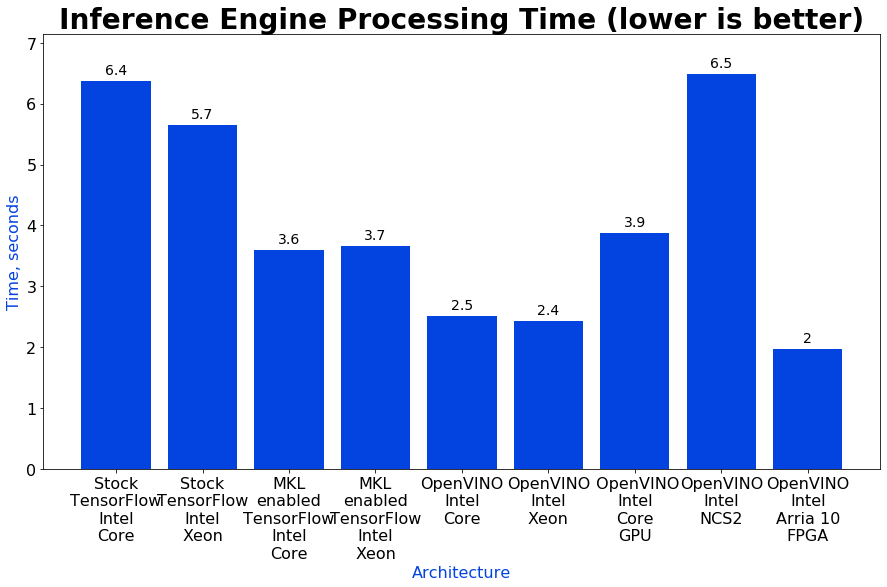

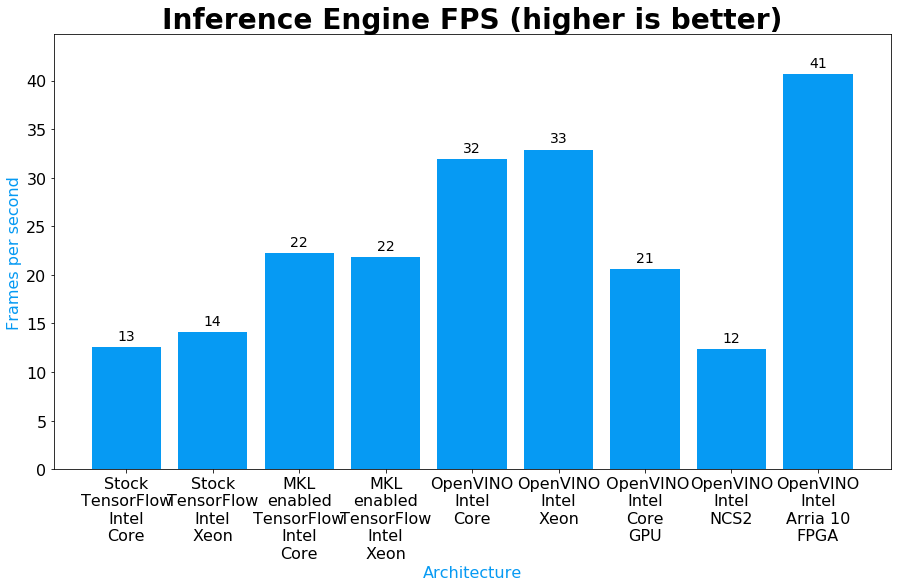

In [21]:
arch_list = [('core_stocktf', 'Stock\nTensorFlow\nIntel\nCore'),
             ('xeon_stocktf', 'Stock\nTensorFlow\nIntel\nXeon'),
             ('core_mkltf', 'MKL\nenabled\nTensorFlow\nIntel\nCore'),
             ('xeon_mkltf', 'MKL\nenabled\nTensorFlow\nIntel\nXeon'),
             ('core_openvino', 'OpenVINO\nIntel\nCore'),
             ('xeon_openvino', 'OpenVINO\nIntel\nXeon'),
             ('gpu_openvino', ' OpenVINO\nIntel\nCore\nGPU'),
             ('ncs2_openvino', 'OpenVINO\nIntel\nNCS2'),
             ('fpga_openvino', 'OpenVINO\nIntel\nArria 10\nFPGA')]

stats_list = []
for job, a_name in arch_list:
    if job in vars():
        stats_list.append(('results/'+vars()[job][0]+'/stats.txt', a_name))
    else:
        stats_list.append(('placeholder'+job, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time (lower is better)', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS (higher is better)', 'fps' )

## Additional Comparisons
The remainder of this notebook shows additional flags that can be passed to the script to do other comparisons.  

*NOTE* Running these cells is optional.

### Comparisons Using a Single Core of CPUs
The following 4 cells run the AI Inferencing using only one core of multiple CPUs.  This is useful when attempting to determine how fast an AI model will execute on a CPU that may be tasked with other workloads simultaneously.  This set of comparisons shows what would happen if a single core was reserved for running the AI.

In [24]:
core_1_stocktf_baseline = !qsub healthcare_job_stocktf.sh -l nodes=1:tank-870:i5-6500te  -F "results/ 0 False"
print(core_1_stocktf_baseline[0]) 
if core_1_stocktf_baseline:
    progressIndicator('results/'+core_1_stocktf_baseline[0], 'i_progress.txt', "Processing", 0, 100)

8036.v-qsvr-1.devcloud-edge


In [25]:
core_1_stocktf = !qsub healthcare_job_stocktf.sh -l nodes=1:tank-870:i5-6500te  -F "results/ 0 True"
print(core_1_stocktf[0]) 
if core_1_stocktf:
    progressIndicator('results/'+core_1_stocktf[0], 'i_progress.txt', "Processing", 0, 100)

8037.v-qsvr-1.devcloud-edge


In [26]:
core_1_mkltf = !qsub healthcare_job_mkltf.sh -l nodes=1:tank-870:i5-6500te  -F "results/ 0 True"
print(core_1_mkltf[0]) 
if core_1_mkltf:
    progressIndicator('results/'+core_1_mkltf[0], 'i_progress.txt', "Processing", 0, 100)

8038.v-qsvr-1.devcloud-edge


In [27]:
core_1_openvino = !qsub healthcare_job_openvino.sh -l nodes=1:tank-870:i5-6500te  -F "CPU results/ 0"
print(core_1_openvino[0]) 
if core_1_openvino:
    progressIndicator('results/'+core_1_openvino[0], 'i_progress.txt', "Processing", 0, 100)

8039.v-qsvr-1.devcloud-edge


### Single Core Processing Comparison
Wait for the above for commands to complete and then run the cell below to plot the relative speeds of the different options.

Here it is easy to see that by simply moving from the stock Python/TensorFlow to the Intel Distribution for Python will, for this model, give about a 2x speed improvement.  There is no need to change anything in the AI Model, etc.  The Intel Distribution of Python is free, so if you want to run AI inferencing on Intel hardware, this should be considered.

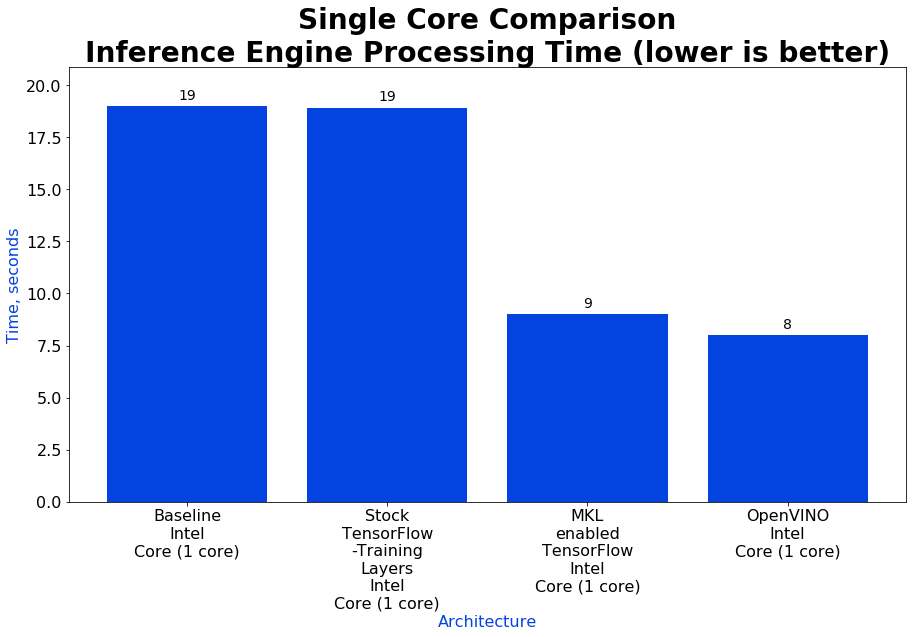

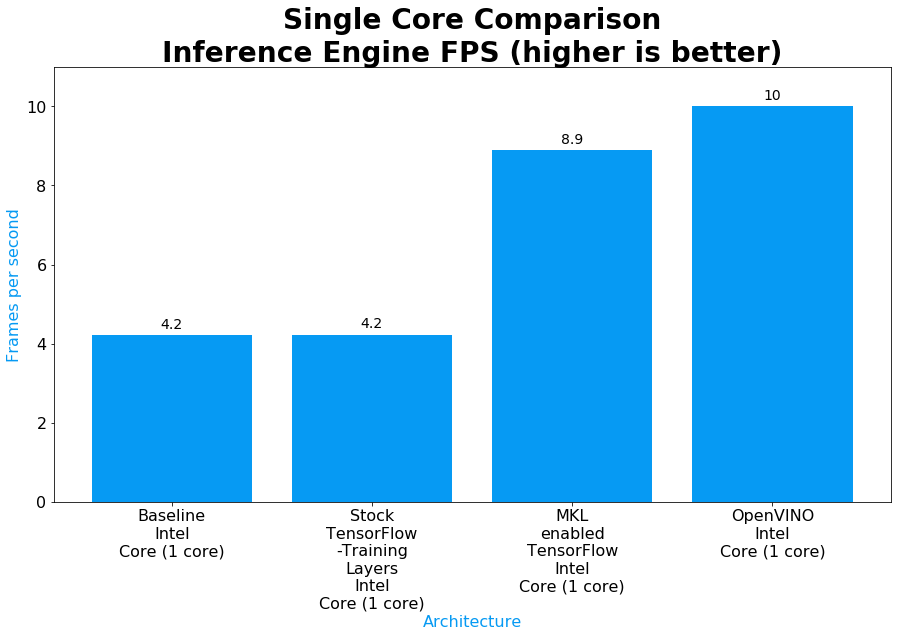

In [28]:
arch_list = [('core_1_stocktf_baseline', 'Baseline\nIntel\nCore (1 core)'),
             ('core_1_stocktf', 'Stock\nTensorFlow\n-Training\nLayers\nIntel\nCore (1 core)'),
             ('core_1_mkltf', 'MKL\nenabled\nTensorFlow\nIntel\nCore (1 core)'),
             ('core_1_openvino', 'OpenVINO\nIntel\nCore (1 core)')]

stats_list = []
for job, a_name in arch_list:
    if job in vars():
        stats_list.append(('results/'+vars()[job][0]+'/stats.txt', a_name))
    else:
        stats_list.append(('placeholder'+job, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Single Core Comparison\nInference Engine Processing Time (lower is better)', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Single Core Comparison\nInference Engine FPS (higher is better)', 'fps' )

### Single Core Versus Four Core Processing Comparison
Using the results from the runs that have already completed, the following cell shows the relative speeds of a single core run versus the four core runs.

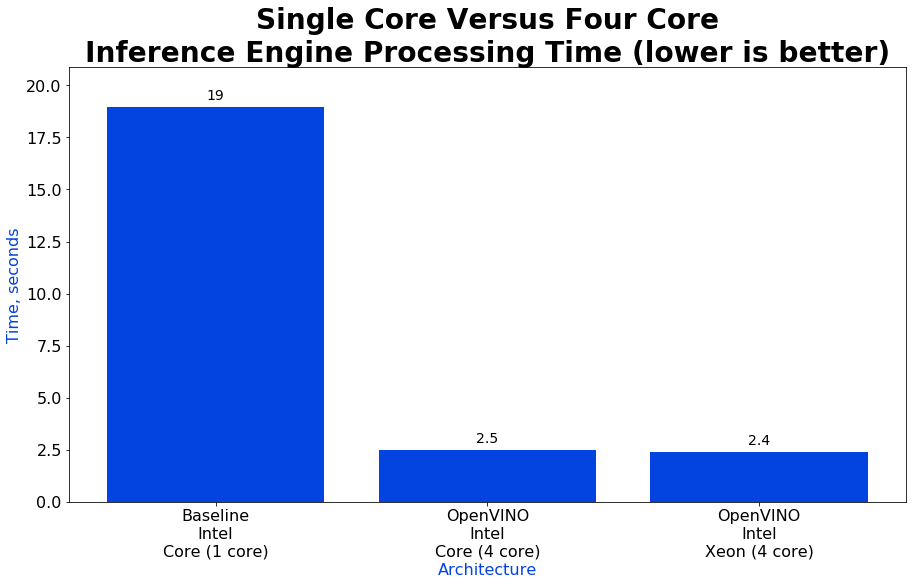

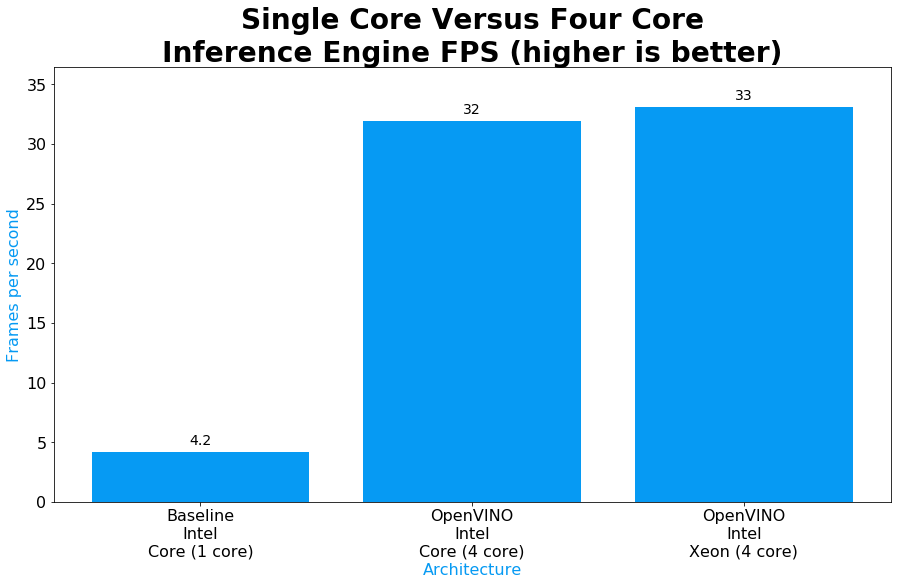

In [30]:
arch_list = [('core_1_stocktf_baseline', 'Baseline\nIntel\nCore (1 core)'),
             ('core_openvino', 'OpenVINO\nIntel\nCore (4 core)'),
             ('xeon_openvino', 'OpenVINO\nIntel\nXeon (4 core)')]

stats_list = []
for job, a_name in arch_list:
    if job in vars():
        stats_list.append(('results/'+vars()[job][0]+'/stats.txt', a_name))
    else:
        stats_list.append(('placeholder'+job, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Single Core Versus Four Core\nInference Engine Processing Time (lower is better)', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Single Core Versus Four Core\nInference Engine FPS (higher is better)', 'fps' )

### Sorted Processing Comparison
Using the results from the runs that have already completed, the following cell should plot the results in sorted order from slowest to fastest.

This shows the advantage of using OpenVINO since the same AI Model can be run on many different types of hardware with very little effort.  The specific selection of hardware to use will depend on the use case.  Is performance speed the most important, or is it low power inferencing, or is it optimizing for lowest hardware costs?  The Intel® DevCloud helps understand the impact of the hardware choices.

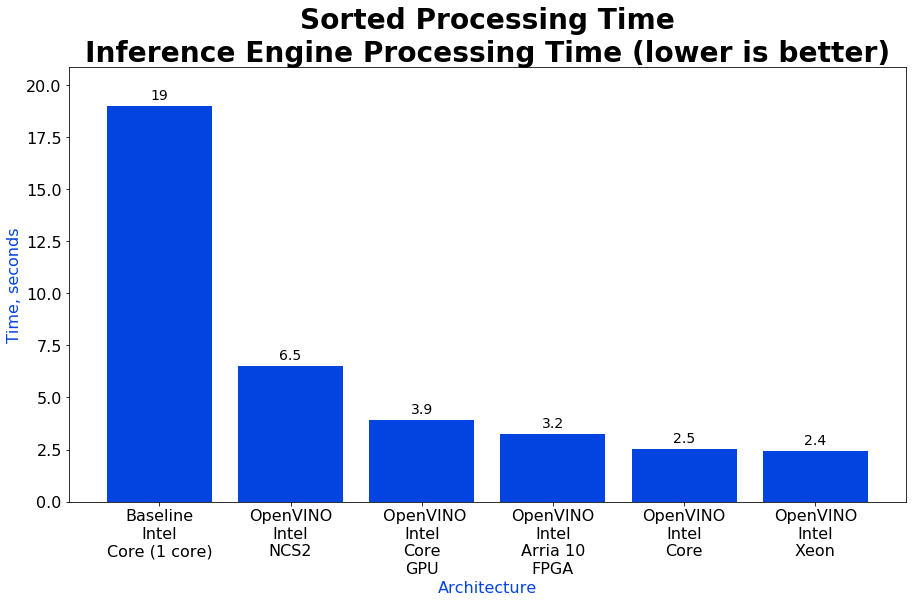

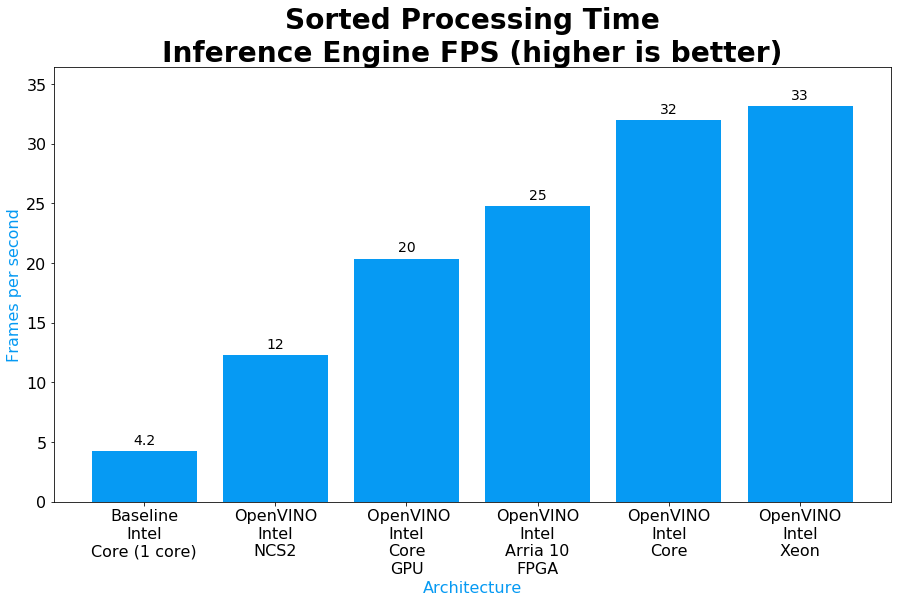

In [31]:
arch_list = [('core_1_stocktf_baseline', 'Baseline\nIntel\nCore (1 core)'),
             ('ncs2_openvino', 'OpenVINO\nIntel\nNCS2'),
             ('gpu_openvino', ' OpenVINO\nIntel\nCore\nGPU'),
             ('fpga_openvino', 'OpenVINO\nIntel\nArria 10\nFPGA'),
             ('core_openvino', 'OpenVINO\nIntel\nCore'),
             ('xeon_openvino', 'OpenVINO\nIntel\nXeon')]

stats_list = []
for job, a_name in arch_list:
    if job in vars():
        stats_list.append(('results/'+vars()[job][0]+'/stats.txt', a_name))
    else:
        stats_list.append(('placeholder'+job, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Sorted Processing Time\nInference Engine Processing Time (lower is better)', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Sorted Processing Time\nInference Engine FPS (higher is better)', 'fps' )

### Comparisons of Adjusting the AI Batch Size
The following cell runs the AI Inferencing using 4 threads (the default) with a batch size of 4 (versus the default 1).  

In [32]:
core_openvino_batch = !qsub healthcare_job_openvino.sh -l nodes=1:tank-870:i5-6500te  -F "CPU results/ 0-3 4 4"
print(core_openvino_batch[0]) 
if core_openvino_batch:
    progressIndicator('results/'+core_openvino_batch[0], 'i_progress.txt', "Processing", 0, 100)

8040.v-qsvr-1.devcloud-edge


### Batch Processing Comparison
After the previous cell completes, run the following cell to see the processing differences between batch sizes.

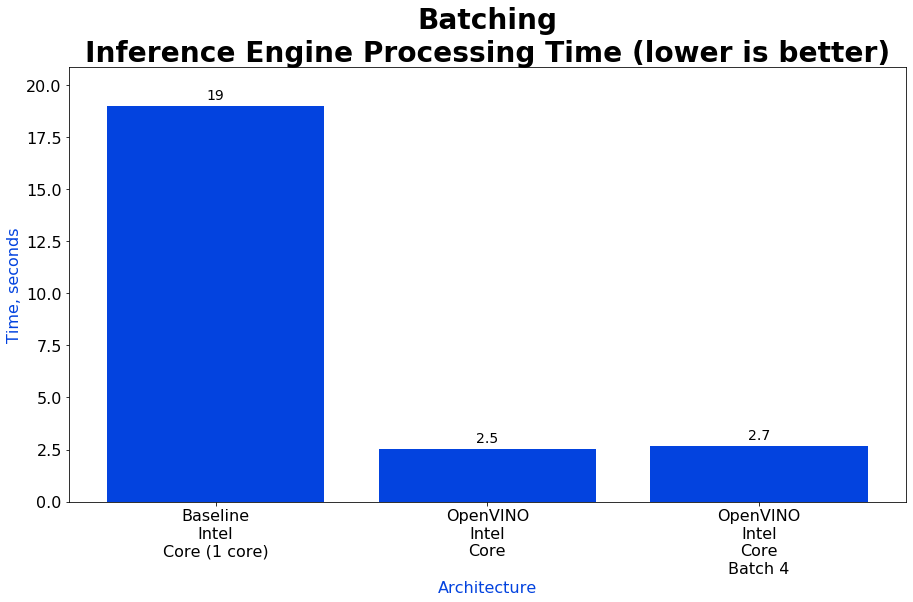

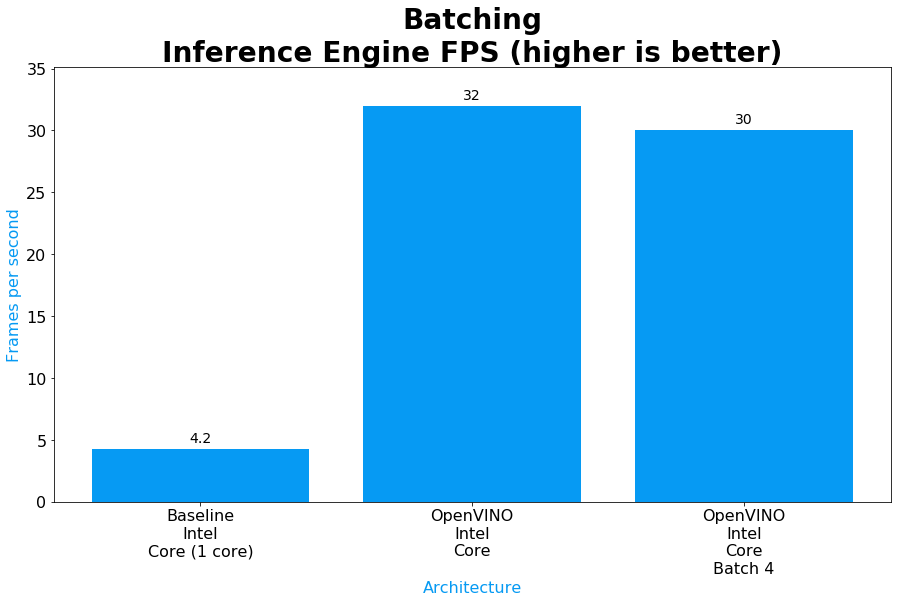

In [33]:
arch_list = [('core_1_stocktf_baseline', 'Baseline\nIntel\nCore (1 core)'),
             ('core_openvino', 'OpenVINO\nIntel\nCore'),
             ('core_openvino_batch', 'OpenVINO\nIntel\nCore\nBatch 4')]

stats_list = []
for job, a_name in arch_list:
    if job in vars():
        stats_list.append(('results/'+vars()[job][0]+'/stats.txt', a_name))
    else:
        stats_list.append(('placeholder'+job, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Batching\nInference Engine Processing Time (lower is better)', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Batching\nInference Engine FPS (higher is better)', 'fps' )